# Skeleton of Assignment 4:

## The significant threshold for the whole exercise
$$ \alpha = 0.05 $$

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#imports downloader
from getCitiBikeCSV import getCitiBikeCSV
from __future__  import print_function
from scipy import stats
import os
#import for location process
from shapely.geometry import Point
import geopandas as gpd

# 0. Read in data
I am reading in data from January 2015 with the function that I created getCitiBikeCSV. You are requested to use 2 months at least. It would be a good idea to use data from a colder and a warmer months, since there are more riders in the warm weather and ridership patterns may change with weather, temperature, etc. You should use data from multiple months, joining multiple datasets (thus addressing some systematic errors as well)

In [2]:
#download file of 2 months. one is colder, the other is warmer.
timeList = ['201601', '201608']
for datestring in enumerate (timeList):
    getCitiBikeCSV(datestring[1])

file in place, you can continue
file in place, you can continue


In [3]:
df1 = pd.read_csv(os.getenv("PUIDATA") + "/" + '201601' + '-citibike-tripdata.csv')
df8 = pd.read_csv(os.getenv("PUIDATA") + "/" + '201608' + '-citibike-tripdata.csv')

In [4]:
result = pd.concat([df1, df8], join='inner', ignore_index=True)
result.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,923,1/1/2016 00:00:41,1/1/2016 00:16:04,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,-74.015756,22285,Subscriber,1958.0,1
1,379,1/1/2016 00:00:45,1/1/2016 00:07:04,476,E 31 St & 3 Ave,40.743943,-73.979661,498,Broadway & W 32 St,40.748549,-73.988084,17827,Subscriber,1969.0,1
2,589,1/1/2016 00:00:48,1/1/2016 00:10:37,489,10 Ave & W 28 St,40.750664,-74.001768,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,21997,Subscriber,1982.0,2
3,889,1/1/2016 00:01:06,1/1/2016 00:15:56,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,-74.015756,22794,Subscriber,1961.0,2
4,1480,1/1/2016 00:01:12,1/1/2016 00:25:52,2006,Central Park S & 6 Ave,40.765909,-73.976342,2006,Central Park S & 6 Ave,40.765909,-73.976342,14562,Subscriber,1952.0,1


In [5]:
result.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')

In [6]:
result.drop(['stoptime', 'start station id', 'start station name', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype', 'gender'], axis=1, inplace=True)
result.head()

,tripduration,starttime,start station latitude,start station longitude,birth year
0,923,1/1/2016 00:00:41,40.719105,-73.999733,1958.0
1,379,1/1/2016 00:00:45,40.743943,-73.979661,1969.0
2,589,1/1/2016 00:00:48,40.750664,-74.001768,1982.0
3,889,1/1/2016 00:01:06,40.719105,-73.999733,1961.0
4,1480,1/1/2016 00:01:12,40.765909,-73.976342,1952.0


In [7]:
result['starttime'] = pd.to_datetime(result['starttime'], format='%m/%d/%Y %H:%M:%S')
result.head()

,tripduration,starttime,start station latitude,start station longitude,birth year
0,923,2016-01-01 00:00:41,40.719105,-73.999733,1958.0
1,379,2016-01-01 00:00:45,40.743943,-73.979661,1969.0
2,589,2016-01-01 00:00:48,40.750664,-74.001768,1982.0
3,889,2016-01-01 00:01:06,40.719105,-73.999733,1961.0
4,1480,2016-01-01 00:01:12,40.765909,-73.976342,1952.0


# Question 1: trip duration of bikers that ride during the day vs night
## 1.1 SPLIT BY CATEGORY

Splitting data by day and night at tripduration:

**H0: there is no statistical difference in the tripduration distribution of day and night trips**

In [8]:
timeuse = result.groupby(result['starttime'].dt.hour).count().loc[:,'start station latitude']
timeuse

starttime
0      18999
1      10713
2       6215
3       3918
4       3940
5      12180
6      47067
7      95668
8     169321
9     135799
10     92143
11     95370
12    105470
13    110103
14    113831
15    119359
16    142383
17    203334
18    198237
19    142666
20     94213
21     65115
22     48672
23     32425
Name: start station latitude, dtype: int64

Define the day is from 8a.m to 7p.m, night is from 8p.m to 7a.m.

In [9]:
dayHour = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
nightHour = [0, 1, 2, 3, 4, 5, 6, 7, 20, 21, 22, 23]
dfDay = pd.DataFrame(columns=['tripduration', 'starttime',
                'start station latitude', 'start station longitude',
                'birth year'])
dfNight = pd.DataFrame(columns=['tripduration', 'starttime',
                'start station latitude', 'start station longitude',
                'birth year'])
for Hour in dayHour:
    dfDay = dfDay.append(result[result['starttime'].dt.hour==Hour])
for Hour in nightHour:
    dfNight = dfNight.append(result[result['starttime'].dt.hour==Hour])
len(dfDay)

1628016

In [10]:
len(dfNight)

439125

In [11]:
dfDay['tripduration'].dropna(inplace= True)
dfNight['tripduration'].dropna(inplace= True)

In [12]:
len(dfNight)

439125

In [13]:
#check if there are outliers
print ("the max value of dfDay is: {}".format(dfDay['tripduration'].max()))
print ("the median value of dfDay is: {}".format(dfDay['tripduration'].median()))
print ("Here are values of different percentage:\n{}".format(
    dfDay.tripduration.quantile([.25, .5, .75, .9, .95, .99, .998])))

the max value of dfDay is: 3966943
the median value of dfDay is: 643.0
Here are values of different percentage:
0.250      388
0.500      643
0.750     1099
0.900     1658
0.950     2052
0.990     3588
0.998    10850
Name: tripduration, dtype: object


There are some outliers at least above the percentange of 0.998.

In [14]:
#detect and exclude outliers
dfDay = dfDay[(np.abs(stats.zscore(dfDay['tripduration'])) < 9)]
dfNight = dfNight[(np.abs(stats.zscore(dfNight['tripduration'])) < 9)]

#print ("the max value of dfDay is: {}".format(dfDay['tripduration'].max()))
#print ("quantile:\n{}".format(dfDay.tripduration.quantile([.25, .5, .75])))
#print ("the max value of dfNight is: {}".format(dfNight['tripduration'].max()))
#print ("quantile:\n{}".format(dfNight.tripduration.quantile([.25, .5, .75])))

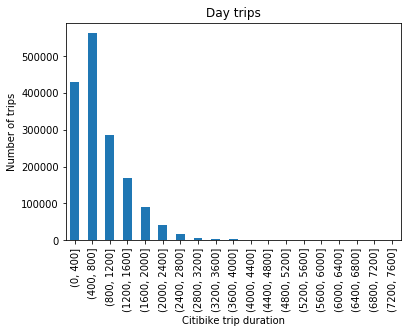

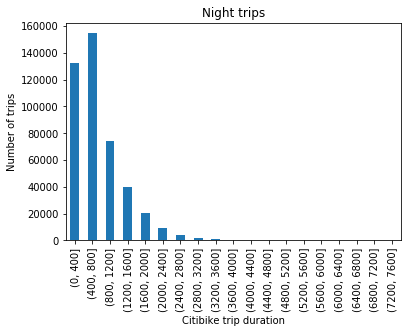

In [15]:
bins = np.arange(0, 8000, 400)
axDay = dfDay.tripduration.groupby(pd.cut(dfDay.tripduration, bins)).agg('count').plot(kind='bar', legend=False)
axDay.set_xlabel("Citibike trip duration")
axDay.set_ylabel("Number of trips")
axDay.set_title("Day trips")
plt.show()
axNight = dfNight.tripduration.groupby(pd.cut(dfNight.tripduration, bins)).agg('count').plot(kind='bar', legend=False)
axNight.set_xlabel("Citibike trip duration")
axNight.set_ylabel("Number of trips")
axNight.set_title("Night trips")
plt.show()

tripduration
(0, 400]        0.036862
(400, 800]      0.043172
(800, 1200]     0.036379
(1200, 1600]    0.023413
(1600, 2000]    0.012885
(2000, 2400]    0.008067
(2400, 2800]    0.005579
(2800, 3200]    0.004235
(3200, 3600]    0.003336
(3600, 4000]    0.002533
(4000, 4400]    0.001990
(4400, 4800]    0.001599
(4800, 5200]    0.001240
(5200, 5600]    0.000926
(5600, 6000]    0.000703
(6000, 6400]    0.000487
(6400, 6800]    0.000305
(6800, 7200]    0.000144
(7200, 7600]    0.000000
Name: tripduration, dtype: float64


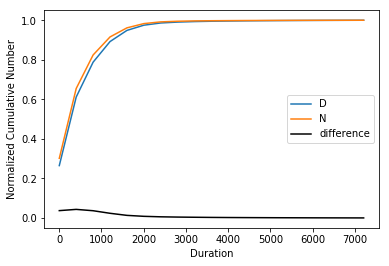

In [16]:
csD=dfDay.tripduration.groupby(pd.cut(dfDay.tripduration, bins)).agg('count').cumsum()

csN=dfNight.tripduration.groupby(pd.cut(dfNight.tripduration, bins)).agg('count').cumsum()

print (np.abs(csD / csD.max()-csN / csN.max()))

plt.plot(bins[:-1] + 5, csD / csD.max(), label = "D")
plt.plot(bins[:-1] + 5, csN / csN.max(), label = "N")
plt.plot(bins[:-1] + 5, np.sqrt(csN / csN.max() - csD / csD.max())**2, 'k-',
        label = "difference")
plt.xlabel("Duration")
plt.ylabel("Normalized Cumulative Number")
plt.legend()


#### Figure 2: The cumulative distribution of citibike trip-durations. The difference mainly occurs during 500 seconds to 2000 seconds.

## 1.2 KS tests to compare 2 samples

http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ks_2samp.html

the KS test in scipy returns the p-value BUT make sure you understand what the NULL is! read the documentation carefully! what is the null hypothesis that you can/cannot reject?

In [17]:
ks = stats.ks_2samp(dfDay.tripduration, dfNight.tripduration)
print (ks)

Ks_2sampResult(statistic=0.043782288537372094, pvalue=0.0)


#### Null hypothesis: The trip durations of bikers that ride during the day vs night have no difference.
#### The KS test returned two values:
#### 1. statistic=0.043782288537372094, is the KS statistic.
#### 2. pvalue = 0.0, the possibility of null hypothesis happens.
#### As pvalue < alpha, we can reject the Null hypothesis.
#### The trip durations of bikers that ride during the day vs night are different.

### With smaller samples:

In [18]:
NdfDay = dfDay.sample(frac=0.005, replace=True)
NdfNight = dfNight.sample(frac=0.005, replace=True)

ks = stats.ks_2samp(NdfDay.tripduration, NdfNight.tripduration)
print (ks)

Ks_2sampResult(statistic=0.054469008688953879, pvalue=6.6038661341587458e-05)


#### Null hypothesis: The trip durations of bikers that ride during the day vs night have no difference.
#### As pvalue < alpha, we can reject the Null hypothesis.
#### The trip durations of bikers that ride during the day vs night are different.

## 1.3 Pearson's  test for correlation

** notice that the Pearson's is a pairwise test: the samples need to be **
 a. the same size
 b. sorted! (how??)
    
http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr



#### Wrangle the data to be paired.

In [19]:
Pday = np.random.choice(dfDay.tripduration, 500)
Pday.sort()
Pnight = np.random.choice(dfNight.tripduration, 500)
Pnight.sort()

In [20]:
stats.pearsonr(Pday, Pnight)

(0.98773513721561579, 0.0)

#### Null Hypothesis: There is no correlation between day and night trip durations.
#### Pearson's corr. coef. = 0.62731398878665345
#### pvalue = 4.7325131238820201e-56
#### As pvalue < alpha, we can reject the Null hypothesis.

## 1.4 Spearman's  test for correlation

http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr

#### Null Hypothesis: There is no correlation between day and night trip durations.

In [21]:
stats.spearmanr(Pday, Pnight)

SpearmanrResult(correlation=0.99999613596729586, pvalue=0.0)

#### Spearman's corr. coef. = 0.9999951039556455
#### pvalue = 0.0
#### As pvalue < alpha, we can reject the Null hypothesis.

# Question 2: age of bikers for trips originating in Manhattan and in Brooklyn
## 2.1 SPLIT BY CATEGORY

In [22]:
result.count()

tripduration               2067141
starttime                  2067141
start station latitude     2067141
start station longitude    2067141
birth year                 1827972
dtype: int64

In [23]:
#drop redundant data
result.drop(['tripduration', 'starttime'], axis=1, inplace=True)
result.dropna(axis=0, how='any', inplace=True)
result.count()

start station latitude     1827972
start station longitude    1827972
birth year                 1827972
dtype: int64

In [24]:
#the data is too big for my computer to compute, I select a portion of it
result = result.sample(frac=0.001, replace=True)

In [25]:
#reset the index
result.reset_index(drop=True, inplace=True)

In [26]:
#turn latitude and longitude into point
locList = []
for row in range(len(result)):
    temp = Point([result['start station longitude'][row],result['start station latitude'][row]])
    locList.append(temp)

result['locPoint'] = pd.Series(locList)
result.head()

,start station latitude,start station longitude,birth year,locPoint
0,40.756405,-73.990026,1975.0,POINT (-73.9900262 40.75640548)
1,40.728846,-74.008591,1998.0,POINT (-74.00859100000001 40.728846)
2,40.711512,-74.015756,1955.0,POINT (-74.01575600000001 40.711512)
3,40.712605,-73.962644,1988.0,POINT (-73.96264403000001 40.71260486)
4,40.720152,-74.010365,1990.0,POINT (-74.01036500930786 40.72015227023285)


In [27]:
result.drop(['start station latitude', 'start station longitude'], axis=1, inplace=True)
result.head()

,birth year,locPoint
0,1975.0,POINT (-73.9900262 40.75640548)
1,1998.0,POINT (-74.00859100000001 40.728846)
2,1955.0,POINT (-74.01575600000001 40.711512)
3,1988.0,POINT (-73.96264403000001 40.71260486)
4,1990.0,POINT (-74.01036500930786 40.72015227023285)


In [28]:
#download geojson file
os.system("curl -O https://raw.githubusercontent.com/lingyielia/PUI2017_lz1714/master/HW4_lz1714/BoroughBoundaries.geojson")
os.system("mv " + "BoroughBoundaries.geojson " + os.getenv("PUIDATA"))

0

In [29]:
df = gpd.read_file(os.getenv("PUIDATA") + "/" + "BoroughBoundaries.geojson")
df

,boro_name,boro_code,shape_leng,shape_area,geometry
0,Staten Island,5,330437.103648,1623914222.74,(POLYGON ((-74.05050806403247 40.5664220341608...
1,Bronx,2,464365.63867,1186678192.09,(POLYGON ((-73.89680883223774 40.7958084451597...
2,Queens,4,895720.956401,3044779902.31,(POLYGON ((-73.83668274106707 40.5949466970158...
3,Brooklyn,3,741077.854437,1937477754.43,(POLYGON ((-73.86706149472118 40.5820879767934...
4,Manhattan,1,361050.577478,636479884.362,(POLYGON ((-74.01092841268031 40.6844914725429...


In [30]:
dfBroo = pd.DataFrame(columns=['birth year', 'locPoint'])
dfManh = pd.DataFrame(columns=['birth year', 'locPoint'])
for point in result['locPoint']:
    if df['geometry'][3].contains(point):
        dfBroo = dfBroo.append(result[result['locPoint']==point])
        dfBroo['locPoint'] = 'Brooklyn'
for point in result['locPoint']:
    if df['geometry'][4].contains(point):
        dfManh = dfManh.append(result[result['locPoint']==point])
        dfManh['locPoint'] = 'Manhattan'

In [31]:
#reset the index
dfBroo.reset_index(drop=True, inplace=True)
dfBroo.head()

,birth year,locPoint
0,1988.0,Brooklyn
1,1973.0,Brooklyn
2,1978.0,Brooklyn
3,1989.0,Brooklyn
4,1979.0,Brooklyn


In [32]:
#reset the index
dfManh.reset_index(drop=True, inplace=True)
dfManh.head()

,birth year,locPoint
0,1975.0,Manhattan
1,1968.0,Manhattan
2,1978.0,Manhattan
3,1975.0,Manhattan
4,1989.0,Manhattan


In [33]:
dfManh.count()

birth year    12117
locPoint      12117
dtype: int64

In [34]:
dfBroo.count()

birth year    547
locPoint      547
dtype: int64

In [35]:
dfManh['age']=2017-dfManh['birth year']
dfBroo['age']=2017-dfBroo['birth year']

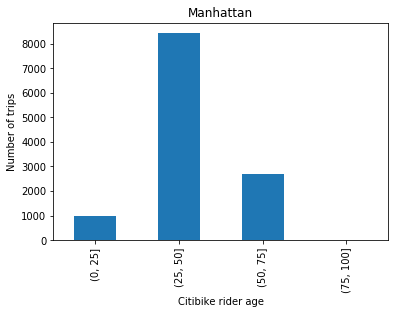

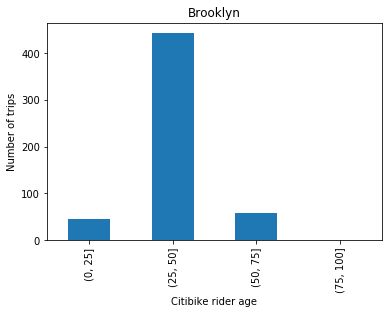

In [36]:
bins = np.arange(0, 101, 25)
axManh = dfManh.age.groupby(pd.cut(dfManh.age, bins)).agg('count').plot(kind='bar', legend=False)
axManh.set_xlabel("Citibike rider age")
axManh.set_ylabel("Number of trips")
axManh.set_title("Manhattan")
plt.show()
axBroo = dfBroo.age.groupby(pd.cut(dfBroo.age, bins)).agg('count').plot(kind='bar', legend=False)
axBroo.set_xlabel("Citibike rider age")
axBroo.set_ylabel("Number of trips")
axBroo.set_title("Brooklyn")
plt.show()

#### Figure 2. The distributions of rider's age from Manhattan and Brooklyn. More people in group 25-50 use citibike.

## 2.2 KS tests to compare 2 samples

In [37]:
ks = stats.ks_2samp(dfManh.age, dfBroo.age)
print (ks)

Ks_2sampResult(statistic=0.14770460888723735, pvalue=1.8825805907007427e-10)


#### Null hypothesis: The age of bikers that ride originating in Manhattan and in Brooklyn have no difference.
#### As pvalue < alpha, we can reject the Null hypothesis.
#### The age of bikers that ride originating in Manhattan and in Brooklyn are different.

In [38]:
NdfManh = dfManh.sample(frac=0.005, replace=True)
NdfBroo = dfBroo.sample(frac=0.005, replace=True)

ks = stats.ks_2samp(NdfManh.age, NdfBroo.age)
print (ks)

Ks_2sampResult(statistic=0.50819672131147542, pvalue=0.32334460514850083)


#### Null hypothesis: The age of bikers that ride originating in Manhattan and in Brooklyn have no difference.
#### As pvalue > alpha, we can not reject the Null hypothesis.
#### The age of bikers that ride originating in Manhattan and in Brooklyn are not significant different.

## 2.3 Pearson's  test for correlation

#### Null Hypothesis: There is no correlation between Manhattan and Brooklyn in terms of the age of riders.

In [39]:
PManh = np.random.choice(dfManh.age, 500)
PManh.sort()
PBroo = np.random.choice(dfBroo.age, 500)
PBroo.sort()

In [40]:
stats.pearsonr(PManh, PBroo)

(0.98414067527128291, 0.0)

#### Pearson's corr. coef. = 0.98414067527128291
#### pvalue = 0.0
#### As pvalue < alpha, we can reject the Null hypothesis. 
#### There is positive correlation between Manhattan and Brooklyn in terms of the age of riders.

## 2.4 Spearman's  test for correlation

#### Null Hypothesis: There is no correlation between Manhattan and Brooklyn in terms of the age of riders.

In [41]:
stats.spearmanr(PManh, PBroo)

SpearmanrResult(correlation=0.99851119955009171, pvalue=0.0)

#### Spearman's corr. coef. = 0.9999951039556455
#### pvalue = 0.0
#### As pvalue < alpha, we can reject the Null hypothesis. 
#### There is positive correlation between Manhattan and Brooklyn in terms of the age of riders.